In [2]:
import keras
from keras.datasets import imdb
from keras.datasets import boston_housing
import numpy as np

keras.__version__

'2.2.4'

# 1. Data Loading

##### __보스턴 주택 가격 데이터셋__
1970년 중반 보스턴 외곽 지역의 범죄율, 지방세율 등의 데이터가 주어졌을 때 주택 가격의 중간 값 예측


1. Per capita crime rate.
2. Proportion of residential land zoned for lots over 25,000 square feet.
3. Proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5. Nitric oxides concentration (parts per 10 million).
6. Average number of rooms per dwelling.
7. Proportion of owner-occupied units built prior to 1940.
8. Weighted distances to five Boston employment centres.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per $10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.  
13. % lower status of the population.

In [3]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 7us/step


In [4]:
train_data.shape, train_targets.shape

((404, 13), (404,))

# 2. Data Preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data)
X_test = scaler.transform(test_data)

# 3. Modeling

In [29]:
from keras import models
from keras import layers
from keras import backend as K

In [10]:
def build_models():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1], )))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

# 4. Model Training

##### Cross Validation

In [137]:
k = 4
num_val_smaples = len(train_data) // k
num_epochs =1000
all_scores = []

for i in range(k):
    print("[{}/{}] PROCESS K-Fold".format(i+1, k))
    
    val_data = train_data[i*num_val_smaples:(i+1)*num_val_smaples]
    val_targets = train_targets[i*num_val_smaples:(i+1)*num_val_smaples]
    
    train_model_data = np.concatenate([train_data[:i*num_val_smaples], 
                                       train_data[(i+1)*num_val_smaples:]], axis=0)
    train_model_targets = np.concatenate([train_targets[:i*num_val_smaples], 
                                          train_targets[(i+1)*num_val_smaples:]], axis=0)
    
    model = build_models()
    history = model.fit(train_model_data, train_model_targets, 
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    
    history_dict = history.history
    #val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(history_dict)

[1/4] PROCESS K-Fold
[2/4] PROCESS K-Fold
[3/4] PROCESS K-Fold
[4/4] PROCESS K-Fold


In [138]:
all_scores[0].keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])

In [139]:
average_mae_history = [ np.mean([x['val_mean_absolute_error'][i] for x in all_scores]) for i in range(num_epochs) ]

In [140]:
len(average_mae_history)

1000

### Training Result

In [141]:
import matplotlib.pyplot as plt

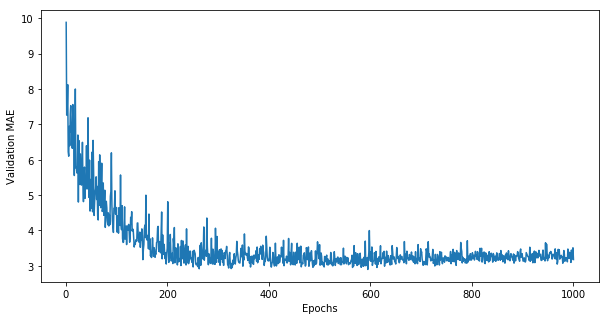

In [142]:
plt.figure(figsize=(10,5))
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [143]:
def smooth_curve(points, factor=0.9):
    
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
            
    return smoothed_points

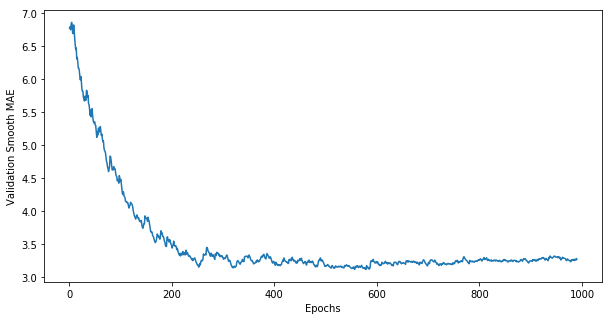

In [144]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.figure(figsize=(10,5))
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation Smooth MAE')
plt.show()

# 5. Prediction

In [147]:
model = build_models()
model.fit(train_data, train_targets, epochs=230, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 2s 15ms/step


In [148]:
test_mae_score

4.650120230282054